# Movie Recommendation System
Author: Pho Khaing

## Collaborative Filtering
#### User-to-User Collaborative Filtering Base on user rating movie
- Select a user with the movies the user has watched
- Based on his rating to movies, find the top X neighbours
- Get the watched movie record of the user for each neighbour.
- Calculate a similarity score using some formula
- Recommend the items with the highest score
- Rated score below 3 (Dislike) and 3,4 or 5 (Like)

In [1]:
import pandas as pd
from scipy import sparse

### Load Data

In [2]:
rating_df = pd.read_csv('movie_rating.csv')
movie_df = pd.read_csv('movies.csv')

### List movie rated

In [3]:
rating_df.head()

,id,user_id,movie_id,rating
0,270,14,21,5
1,271,15,21,3
2,272,15,34,3
3,273,15,23,5
4,276,14,23,2


###  All movies

In [4]:
movie_df = movie_df.drop(['genre','movie_logo'],axis=1) # remove colomn genre, movie_logo
movie_df.head()

,id,title
0,18,12 Angry Men
1,19,12 Years a Slave
2,20,A Beautiful Mind
3,21,Avatar
4,22,Avengers: Infinity War


### Merge movie_df with rating_df

In [5]:
movie_rating_df = rating_df.merge(movie_df,left_on='movie_id', right_on='id')
movie_rating_df.head()
print('Shape:', movie_rating_df.shape)

Shape: (7, 6)


### List all user rated on movies as Pivot Table

In [6]:
user_rating_df= movie_rating_df.pivot_table(index=['user_id'],columns=['movie_id'],values='rating')
user_rating_df.head()

movie_id,21,23,24,34,54
user_id,,,,,
8,NaN,NaN,2.0,NaN,NaN
14,5.0,2.0,NaN,NaN,NaN
15,3.0,5.0,NaN,3.0,NaN
16,NaN,NaN,NaN,NaN,5.0


Fill remaining NaN with 0

In [7]:
user_rating_df = user_rating_df.fillna(0,axis=1)
user_rating_df.head()

movie_id,21,23,24,34,54
user_id,,,,,
8,0.0,0.0,2.0,0.0,0.0
14,5.0,2.0,0.0,0.0,0.0
15,3.0,5.0,0.0,3.0,0.0
16,0.0,0.0,0.0,0.0,5.0


Let's remove movie which have less than 10 who rated it, and fill remaining NaN with 0
if we have lots of movie rated, so we show movie's rated over 10 only

In [8]:
# print("Before: ",user_rating_df.shape)

# Let's remove movie which have less than 10 who rated it, and fill remaining NaN with 0
# user_rating_df = user_rating_df.dropna(thresh=10, axis=1).fillna(0,axis=1)
# userRatings.fillna(0, inplace=True)
# print("After: ",user_rating_df.shape)

### Similarity of users to input user
Next, we are going to compare all users (not really all !!!) to our specified user and find the one that is most similar.
we're going to find out how similar each user is to the input through the Pearson Correlation Coefficient. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below.

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 * Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

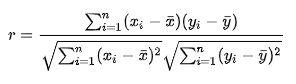

We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.

In [9]:
### Let's build our Pearson Correlation Similarity Matrix

In [10]:
corrMatrix = user_rating_df.corr(method='pearson')
print('Shape:', corrMatrix.shape)
corrMatrix.head()

Shape: (5, 5)


movie_id,21,23,24,34,54
movie_id,,,,,
21,1.000000,0.633504,-0.544331,0.272166,-0.544331
23,0.633504,1.000000,-0.493742,0.916949,-0.493742
24,-0.544331,-0.493742,1.000000,-0.333333,-0.333333
34,0.272166,0.916949,-0.333333,1.000000,-0.333333
54,-0.544331,-0.493742,-0.333333,-0.333333,1.000000


### Let's Make Recommendations
- score less than 3 is Dislike, so move that movie to down(that why use -2.5)
- score 3, 4 or 5 is Like, so show that movie to top

In [11]:
def get_similar_movie(movie_id, rating_score):
    similar_ratings = corrMatrix[movie_id] * (rating_score-2.5) 
    similar_ratings = similar_ratings.sort_values(ascending=False) # Order score DESC
    #print(type(similar_ratings))
    return similar_ratings

### Let's test rating movie here

In [12]:
# rating_movie = [(movie_id, rating_scor)]
my_rating_movie = [
    (21, 2),
]

similar_movies = pd.DataFrame()
for movie,rating in my_rating_movie:
    similar_movies = similar_movies.append(get_similar_movie(movie, rating), ignore_index=True)

print("Result Recommendation Movie:")
similar_movies.head(10) # show limit 10 rows

Result Recommendation Movie:


C:\Users\khaing\AppData\Local\Temp\ipykernel_1572\645064194.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar_movie(movie, rating), ignore_index=True)


movie_id,24,54,34,23,21
0,0.272166,0.272166,-0.136083,-0.316752,-0.5


### Sum result similar movie

In [13]:
similar_movies.sum().sort_values(ascending=False).head(20)

movie_id
24    0.272166
54    0.272166
34   -0.136083
23   -0.316752
21   -0.500000
dtype: float64